In [1]:
import random
import pandas as pd
import matplotlib.pyplot as plt

# Loading the dataset
file_path = '../cleaner/cleaned_ads_dimension.csv'
data = pd.read_csv(file_path)

# Displaying the first few rows of the dataset
data.head()

,ad_id,delivery_country,punish_num,avg_ad_revenue,baseline_st
0,1747578422390810,US,1,4795.250,1.78
1,1758543228094480,SA,1,1063.767,1.67
2,1738303151826990,AU,2,5.365,1.84
3,1738303920938010,NZ,2,5.365,1.58
4,1738304016410620,NZ,2,5.365,1.58


In [2]:
# Convert to max-max problem
data["punish_num"] *= -1

# Step 1: Identifying the Nadir and Utopia points
utopia_point = [data['avg_ad_revenue'].max(), data['punish_num'].max()]
nadir_point = [data['avg_ad_revenue'].min(), data['punish_num'].min()]

# Step 2: Normalizing the objective values
data['normalized_avg_ad_revenue'] = (data['avg_ad_revenue'] - utopia_point[0]) / (nadir_point[0] - utopia_point[0])
data['normalized_punish_num'] = (data['punish_num'] - utopia_point[1]) / (nadir_point[1] - utopia_point[1])

# Step 3: Recalculating the distance to Utopia point using the normalized values
data['normalized_distance_to_utopia'] = ((data['normalized_avg_ad_revenue'] - 0)**2 + (data['normalized_punish_num'] - 0)**2)**0.5

# Displaying the first few rows of the dataset with the new normalized columns
data.head()


,ad_id,delivery_country,punish_num,avg_ad_revenue,baseline_st,normalized_avg_ad_revenue,normalized_punish_num,normalized_distance_to_utopia
0,1747578422390810,US,-1,4795.250,1.78,0.720304,0.0625,0.723010
1,1758543228094480,SA,-1,1063.767,1.67,0.937953,0.0625,0.940033
2,1738303151826990,AU,-2,5.365,1.84,0.999687,0.1250,1.007472
3,1738303920938010,NZ,-2,5.365,1.58,0.999687,0.1250,1.007472
4,1738304016410620,NZ,-2,5.365,1.58,0.999687,0.1250,1.007472


In [3]:
# Step 5: Ranking the Records Based on Priority
data['priority_rank'] = data.groupby('delivery_country')['normalized_distance_to_utopia'].rank(method='first')

# Step 6: Generating the Queues
queues = data.sort_values(by=['delivery_country', 'priority_rank']).groupby('delivery_country')['ad_id'].apply(list)

# Displaying the first few queues
queues.head()


delivery_country
AE    [1772824938410000, 1771639952060430, 177175490...
AR    [1767234953622530, 1769982368863240, 177231827...
AT    [1773293685750830, 1773293685750830, 177320547...
AU    [1773563867768910, 1765107022556160, 176510702...
BE    [1773205472709660, 1758841989024770, 177356037...
Name: ad_id, dtype: object

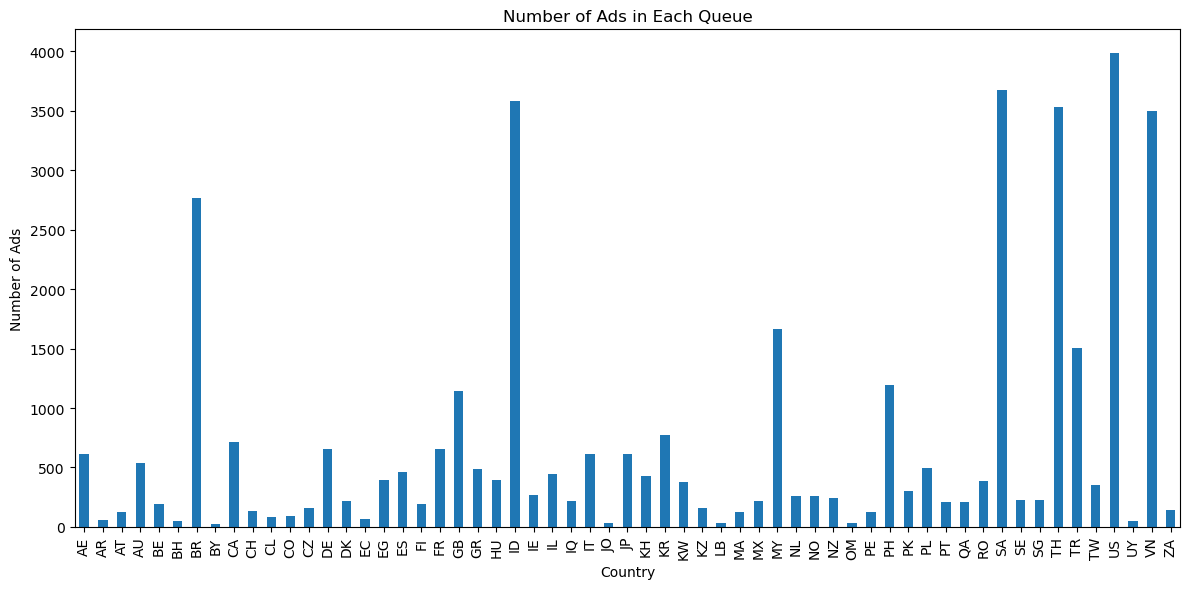

In [4]:
# Counting the number of ads in each queue
queue_lengths = queues.apply(len)

# Creating a bar plot to visualize the number of ads in each queue
plt.figure(figsize=(12, 6))
queue_lengths.plot(kind='bar')
plt.xlabel('Country')
plt.ylabel('Number of Ads')
plt.title('Number of Ads in Each Queue')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [5]:
# Load the moderator data
mod_data = pd.read_csv('../cleaner/cleaned_moderator_dimension.csv')
# Renaming the accuracy column to remove extra whitespaces
mod_data.rename(columns={'  accuracy  ': 'accuracy'}, inplace=True)
# Display the first few rows of the moderator data to understand its structure
mod_data.head()

,moderator,Productivity,Utilisation %,handling time,accuracy,AE,AR,AT,AU,BE,...,TH,TN,TR,TW,UA,US,UY,UZ,VN,ZA
0,1689841547143170,286.217674,0.812403,123549,-,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1686755036370945,174.560000,0.704833,25547,0.959,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1741913197768705,334.376000,0.819167,50794,1.000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1743415203890193,452.277500,0.775474,89626,0.941,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,1710346282427393,612.312500,0.843229,98066,0.887,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# Cleaning the accuracy column and converting it to a numeric type
mod_data['accuracy'] = pd.to_numeric(mod_data['accuracy'], errors='coerce')

# Calculating the score and daily capacity for each moderator
mod_data['score'] = (mod_data['Productivity'] * mod_data['Utilisation %'] * mod_data['accuracy']) / mod_data['handling time']
mod_data['daily_capacity'] = (mod_data['Productivity'] * mod_data['Utilisation %']).astype(int)

# Displaying the first few rows of the data with the calculated scores and daily capacity
mod_data.head()

,moderator,Productivity,Utilisation %,handling time,accuracy,AE,AR,AT,AU,BE,...,TR,TW,UA,US,UY,UZ,VN,ZA,score,daily_capacity
0,1689841547143170,286.217674,0.812403,123549,NaN,0,0,0,0,0,...,0,0,0,0,0,0,0,0,NaN,232
1,1686755036370945,174.560000,0.704833,25547,0.959,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.004619,123
2,1741913197768705,334.376000,0.819167,50794,1.000,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0.005393,273
3,1743415203890193,452.277500,0.775474,89626,0.941,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0.003682,350
4,1710346282427393,612.312500,0.843229,98066,0.887,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.004670,516


In [8]:
def assign_ads_to_mods(queue, mod_data):
    # Step 1: Initialize an empty dictionary to store the assignments
    assignments = {}

    # Step 2: Iterate through the ad data series country-wise
    for country, ads in queue.iteritems():

        # Step 3: Identify the moderators who oversee the respective country and have valid scores
        eligible_mods = mod_data[(mod_data[country] == 1) & mod_data['score'].notna()].copy()
        
        # If there are no eligible mods for a country, continue to the next country
        if eligible_mods.empty:
            continue
        
        # Sort the eligible moderators based on their scores in descending order
        eligible_mods.sort_values(by='score', ascending=False, inplace=True)
        
        # Step 5: Assign ads to moderators based on their scores and daily capacity
        ad_queue = list(ads)
        for _, mod in eligible_mods.iterrows():
            if not ad_queue:
                break
                
            assigned_ads = []
            for _ in range(min(int(mod['daily_capacity']), len(ad_queue))):
                assigned_ads.append(ad_queue.pop(0))
            
            # Update the assignments dictionary
            if assigned_ads:
                assignments[mod['moderator']] = assigned_ads
    
    # Step 6: Return the dictionary with the assignments
    return assignments

In [9]:
# Running the function with the ad data series and moderator data
assignments = assign_ads_to_mods(queues, mod_data)

# Displaying the first assignments as an example output
dict(list(assignments.items())[:1])

/var/folders/9j/1bsg37c11p55zns33dj9tr3c0000gn/T/ipykernel_4709/1794019558.py:6: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for country, ads in queue.iteritems():


{1958955.0: [1772824938410000,
  1771639952060430,
  1771754906530830,
  1772391988888610,
  1771680101787690,
  1760366691144720,
  1773439605252090,
  1772468246696960,
  1772946182003740,
  1772628620777500,
  1771387678152750,
  1771388794475530,
  1772318695395360,
  1773212785233920,
  1773464609528830,
  1773482289162240,
  1766314378324030,
  1763070519096330,
  1772461683919900,
  1765500335365170,
  1773299655317520,
  1765710157502460,
  1773522284887070,
  1773522318441500,
  1770501750751240,
  1770729324566570,
  1770729324566570,
  1771281787754530,
  1771281787754530,
  1771116365845520,
  1771210452412430,
  1771301192620050,
  1773538912813100,
  1773534469479420,
  1773307911856170,
  1773307911856170,
  1773307911856170,
  1773307911856170,
  1773307911856170,
  1773307911856170,
  1770540310140920,
  1772956737568770,
  1773404180712450,
  1773496827184120,
  1767100160054300,
  1767100264605710,
  1768033175956480,
  1768656371969020,
  1773194793107550,
  1773505

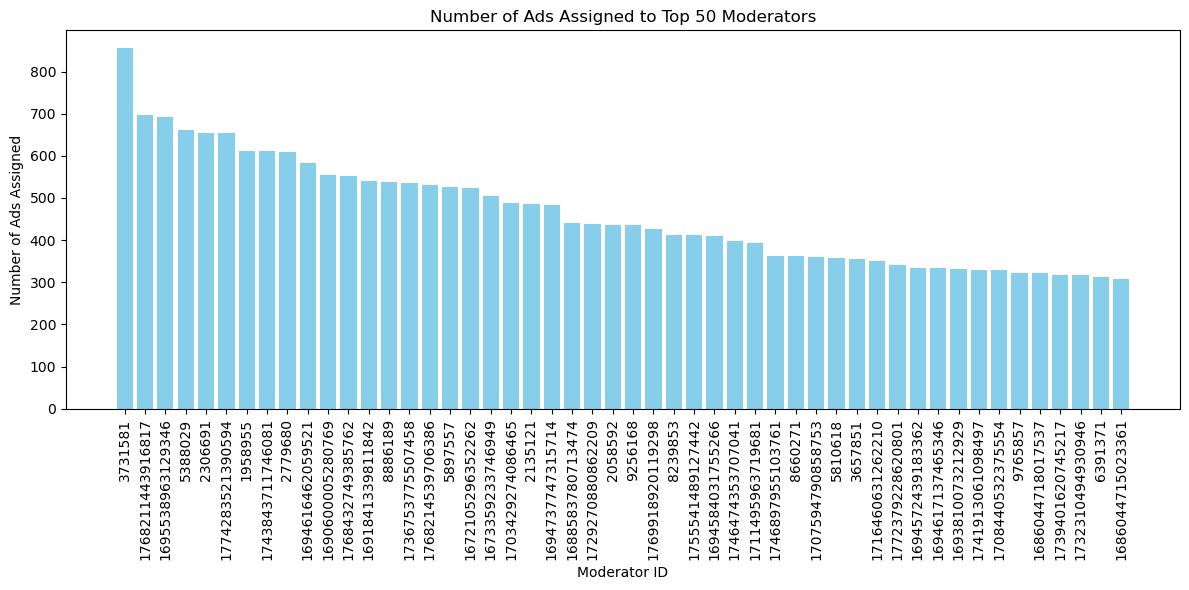

In [11]:
# Calculating the number of ads assigned to each moderator
mod_assignment_counts = {mod: len(ads) for mod, ads in assignments.items()}

# Converting all moderator IDs to strings
mod_assignment_counts_str = {str(int(mod)): count for mod, count in mod_assignment_counts.items()}

# Sorting the dictionary by the number of ads assigned to each moderator in descending order and getting the top 50
sorted_mod_assignment_counts_str = {k: v for k, v in sorted(mod_assignment_counts_str.items(), key=lambda item: item[1], reverse=True)}
top_50_mods_str = list(sorted_mod_assignment_counts_str.keys())[:50]
top_50_assignment_counts_str = list(sorted_mod_assignment_counts_str.values())[:50]

# Creating a bar plot for the top 50 moderators
plt.figure(figsize=(12, 6))
plt.bar(top_50_mods_str, top_50_assignment_counts_str, color='skyblue')

# Adding titles and labels
plt.title('Number of Ads Assigned to Top 50 Moderators')
plt.xlabel('Moderator ID')
plt.ylabel('Number of Ads Assigned')
plt.xticks(rotation=90)

# Displaying the plot
plt.tight_layout()
plt.show()

In [36]:
def initialize_population_with_unassigned_tracking(queue, mod_data, population_size):
    # Getting the list of moderator IDs and their daily capacities
    mod_ids = mod_data['moderator'].tolist()
    daily_capacities = mod_data['daily_capacity'].tolist()
    
    # Creating a dictionary to store the daily capacities of moderators
    mod_daily_capacity_dict = dict(zip(mod_ids, daily_capacities))
    
    # Getting the list of ads for each country
    country_ads_dict = queue.to_dict()
    
    # Initializing a list to store the population and unassigned ads
    population = []
    unassigned_ads_list = []
    
    # Creating the initial population
    for _ in range(population_size):
        # Creating a dictionary to represent an individual
        individual = {mod_id: [] for mod_id in mod_ids}
        
        # Assigning ads to moderators randomly
        unassigned_ads = []
        for country, ads in country_ads_dict.items():
            # Getting the list of moderators for the country
            eligible_mods = mod_data[mod_data[country] == 1]['moderator'].tolist()
            
            # Shuffling the list of ads and moderators
            random.shuffle(ads)
            random.shuffle(eligible_mods)
            
            # Assigning ads to moderators
            ad_index = 0
            for mod_id in eligible_mods:
                for _ in range(mod_daily_capacity_dict[mod_id]):
                    if ad_index < len(ads):
                        individual[mod_id].append(ads[ad_index])
                        ad_index += 1
                    else:
                        break
            
            # Tracking any unassigned ads
            unassigned_ads.extend(ads[ad_index:])
        
        # Adding the individual to the population and tracking unassigned ads
        population.append(individual)
        unassigned_ads_list.append(unassigned_ads)
    
    return population, unassigned_ads_list

# Updating the function to handle NaN values in the scores
def evaluate_fitness(individual, mod_data):
    # Creating a dictionary to store the scores of moderators and replacing NaN scores with 0
    mod_score_dict = dict(zip(mod_data['moderator'], mod_data['score'].fillna(0)))
    
    # Calculating the total score of the individual
    total_score = sum(len(assigned_ads) * mod_score_dict[mod_id] for mod_id, assigned_ads in individual.items())
    
    return total_score

# Function to evaluate the fitness of a population
def evaluate_population_fitness(population, mod_data):
    # Evaluating the fitness of each individual in the population
    fitness_values = [evaluate_fitness(ind, mod_data) for ind in population]
    
    return fitness_values

# Function to perform tournament selection
def tournament_selection(population, fitness_values, tournament_size):
    selected_parents = []
    population_size = len(population)
    
    for _ in range(population_size):
        # Randomly selecting individuals for the tournament
        tournament_individuals = random.sample(list(zip(population, fitness_values)), tournament_size)
        
        # Selecting the best individual from the tournament
        best_individual = max(tournament_individuals, key=lambda x: x[1])
        
        # Adding the best individual to the selected parents
        selected_parents.append(best_individual[0])
    
    return selected_parents

# Function to perform one-point crossover
def one_point_crossover(parent1, parent2):
    # Getting the list of keys (moderator IDs)
    keys = list(parent1.keys())
    
    # Randomly selecting a crossover point
    crossover_point = random.randint(0, len(keys) - 1)
    
    # Creating two new offspring
    offspring1 = {}
    offspring2 = {}
    
    # Performing the crossover operation
    for i in range(len(keys)):
        if i < crossover_point:
            offspring1[keys[i]] = parent1[keys[i]]
            offspring2[keys[i]] = parent2[keys[i]]
        else:
            offspring1[keys[i]] = parent2[keys[i]]
            offspring2[keys[i]] = parent1[keys[i]]
    
    return offspring1, offspring2

# Function to form the next generation
def form_next_generation(selected_parents, mod_data, mutation_rate, population_size):
    # Creating a new generation using crossover and mutation
    new_generation = []
    for i in range(0, population_size, 2):
        # Performing one-point crossover to create two offspring
        offspring1, offspring2 = one_point_crossover(selected_parents[i], selected_parents[i+1])
        
        # Performing mutation on the offspring
        offspring1 = mutate(offspring1, mutation_rate)
        offspring2 = mutate(offspring2, mutation_rate)
        
        # Adding the offspring to the new generation
        new_generation.append(offspring1)
        new_generation.append(offspring2)
    
    # Evaluating the fitness of the new generation
    new_generation_fitness = evaluate_population_fitness(new_generation, mod_data)
    
    # Selecting the best individuals to form the next generation
    next_generation = [x for _, x in sorted(zip(new_generation_fitness, new_generation), reverse=True)]
    
    return next_generation, new_generation_fitness

# Function to perform mutation
def mutate(individual, mutation_rate):
    # Getting the list of keys (moderator IDs)
    keys = list(individual.keys())
    
    # Deciding whether to mutate the individual based on the mutation rate
    if random.random() < mutation_rate:
        # Randomly selecting a moderator to remove ads from
        mod_to_remove_from = random.choice(keys)
        
        # Checking if the selected moderator has any ads assigned
        if len(individual[mod_to_remove_from]) > 0:
            # Randomly selecting a number of ads to remove (between 1 and the number of ads assigned to the moderator)
            num_ads_to_remove = random.randint(1, len(individual[mod_to_remove_from]))
            
            # Removing the ads
            ads_to_reassign = [individual[mod_to_remove_from].pop() for _ in range(num_ads_to_remove)]
            
            # Randomly selecting a different moderator to assign the ads to
            mod_to_assign_to = random.choice([key for key in keys if key != mod_to_remove_from])
            
            # Assigning the ads to the selected moderator
            individual[mod_to_assign_to].extend(ads_to_reassign)
    
    return individual

# Main function to run the genetic algorithm
def genetic_algorithm(queue, mod_data, num_generations, population_size, tournament_size, mutation_rate):
    # Step 1: Initialization
    population, _ = initialize_population_with_unassigned_tracking(queue, mod_data, population_size)
    
    # Step 2: Evaluation
    fitness_values = evaluate_population_fitness(population, mod_data)
    
    # Step 3: Main Loop
    for generation in range(num_generations):
        # Selection
        selected_parents = tournament_selection(population, fitness_values, tournament_size)
        
        # Crossover, Mutation, and Replacement
        population, fitness_values = form_next_generation(selected_parents, mod_data, mutation_rate, population_size)
        
        # Printing the best fitness value in each generation as a log
        print(f"Generation {generation+1}: Best Fitness = {max(fitness_values)}")
    
    # Step 4: Result
    # Getting the best solution from the final population
    best_solution = max(zip(population, fitness_values), key=lambda x: x[1])[0]
    
    return best_solution

In [42]:
# Parameters for the genetic algorithm
num_generations = 50
population_size = 100
tournament_size = 5
mutation_rate = 0.2

# Running the genetic algorithm
best_solution = genetic_algorithm(queues, mod_data, num_generations, population_size, tournament_size, mutation_rate)

# Displaying the first few keys and values of the best solution as an example
dict(list(best_solution.items())[:2])

Generation 1: Best Fitness = 215.41722804420468
Generation 2: Best Fitness = 209.31967705026287
Generation 3: Best Fitness = 221.90051664949036
Generation 4: Best Fitness = 231.98037822277973
Generation 5: Best Fitness = 231.98037822277973
Generation 6: Best Fitness = 207.04781466253175
Generation 7: Best Fitness = 205.014833868585
Generation 8: Best Fitness = 193.95922578222667
Generation 9: Best Fitness = 195.86885384473626
Generation 10: Best Fitness = 194.5534472654373
Generation 11: Best Fitness = 182.8238166307986
Generation 12: Best Fitness = 183.2015928728776
Generation 13: Best Fitness = 171.2397948099921
Generation 14: Best Fitness = 178.07940378962525
Generation 15: Best Fitness = 171.58864465746558
Generation 16: Best Fitness = 168.3395602757275
Generation 17: Best Fitness = 166.7712578511499
Generation 18: Best Fitness = 162.67190402028967
Generation 19: Best Fitness = 168.64429649211183
Generation 20: Best Fitness = 171.2830848011163
Generation 21: Best Fitness = 175.2788

{1689841547143170: [1773097804817400,
  1773569648738350,
  1773536454708220,
  1773444284170240,
  1773451770089470,
  1773488560415740,
  1773564452891640,
  1773416466177020,
  1773413578696700,
  1773356593261570,
  1773591383961600,
  1773435374873600,
  1773584566599680,
  1773451211879420,
  1773569490821160,
  1773342927476730,
  1773143934080010,
  1773572954235900,
  1773580604184570,
  1773509216465920,
  1773566311762940,
  1773224016348160,
  1773428417346560,
  1773102031223850,
  1773426332911620,
  1773515105447930,
  1773441550904320,
  1773518146845690,
  1773562511660030,
  1773424735910910,
  1773475347757050,
  1773505658888190,
  1773316939226110,
  1773488585590780,
  1773538056045570,
  1773077544838140,
  1773600965136390,
  1773492457077760,
  1773587879087100,
  1773517757689850,
  1773421350936570,
  1773324837615610,
  1773414080659450,
  1773536762358780,
  1773556495768570,
  1773475429087230,
  1773420464657400,
  1773489339159550,
  1773586368116750,
  

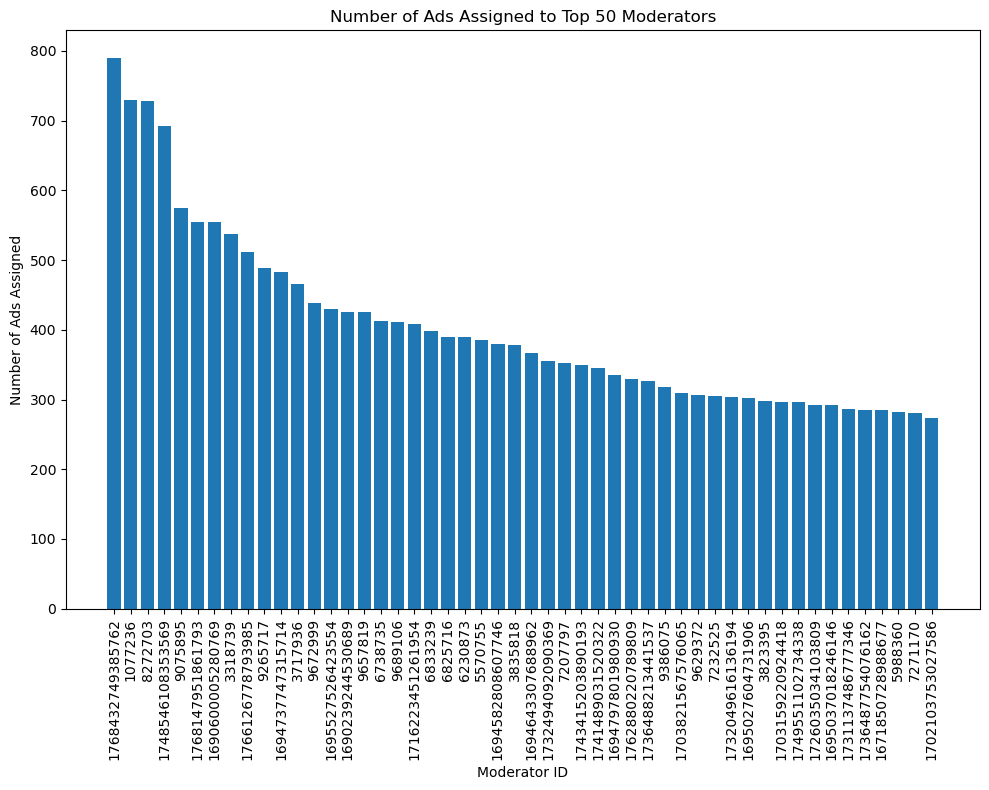

In [43]:
# Extracting the number of ads assigned to each moderator in the best solution
num_ads_assigned = [len(ads) for ads in best_solution.values()]

# Creating a DataFrame to store the moderator IDs and the number of ads assigned to them
mod_assignment_df = pd.DataFrame({
    'moderator': list(best_solution.keys()),
    'num_ads_assigned': num_ads_assigned
})

# Getting the top 50 moderators based on the number of ads assigned
top_50_mods = mod_assignment_df.nlargest(50, 'num_ads_assigned')

# Plotting the number of ads assigned to the top 50 moderators
plt.figure(figsize=(10, 8))
plt.bar(top_50_mods['moderator'].astype(str), top_50_mods['num_ads_assigned'])
plt.xlabel('Moderator ID')
plt.ylabel('Number of Ads Assigned')
plt.title('Number of Ads Assigned to Top 50 Moderators')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [41]:
len(mod_data)
len(data)

40679